## Introduccion

En este proyecto queremos preparar un  prototipo de un modelo de ML para Zyfra. La empresa desarrolla soluciones de eficiencia para la industria pesada. El modelo debe predecir la cantidad de oro extraído del mineral de oro. Disponemos de los datos de extracción y purificación, aunque estos pueden tener algunos problemas. Es por esto que uno de nuestros primeros pasos será verificar si estos son correctos al comprobar si el cálculo de la recuperación es correcto.

Luego analizaremos los datos y veremos como cambian las concentraciones de los metales (Au, Ag, Pb) en función de la etapa de purificación.

Finalmente, construiremos y entrenaremos nuestros modelos. Se compararán diferentes modelos y se evaluarán utilizando la validación cruzada, para luego testear el mejor de estos con la muestra de prueba.

- Objetivos

1. Comprobar y preparar los datos.
2. Analizar los datos.
3. Desarrollar un modelo que prediga la cantidad de oro extraído del mineral de oro.

## Importamos librerias.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

from numpy.random import RandomState

from sklearn.dummy import DummyRegressor

from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer

from sklearn.multioutput import MultiOutputRegressor

from sklearn.model_selection import cross_val_score, cross_validate, train_test_split

from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

## Cargamos datos.

In [2]:
# Cargamos DataFrames
df_train = pd.read_csv('/datasets/gold_recovery_train.csv')
df_test = pd.read_csv('/datasets/gold_recovery_test.csv')
df_full = pd.read_csv('/datasets/gold_recovery_full.csv')

In [3]:
# Revisamos el tamaño de los DataFrames.
df_train.shape

(16860, 87)

In [4]:
df_test.shape

(5856, 53)

In [5]:
df_full.shape

(22716, 87)

In [6]:
# Revisamos que el tamaño de los DataFrames train y test correspondan al full.
len(df_test)+len(df_train)

22716

Vemos que el dataframe de prueba tiene menos columnas que los otros por lo tanto vamos a revisar cuales columnas no contiene ya que pueden ser columnas que necesitemos para el analisis.

In [7]:
columns_train = df_train.columns
columns_test = df_test.columns

columns_rest = columns_train.drop(columns_test)

print(len(columns_rest))
columns_rest

34


Index(['final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.concentrate_au',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb',
       'final.output.tail_sol', 'final.output.tail_au',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb',
       'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au',
       'rougher.calculation.sulfate_to_au_concentrate',
       'rougher.calculation.floatbank10_sulfate_to_au_feed',
       'rougher.calculation.floatbank11_sulfate_to_au_feed',
       'rougher.calculation.au_pb_ratio', 'rougher.output.concentrate_ag',
       'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol',
       'rougher.output.concentrate_au', 'rougher.outpu

Las columnas que nos faltan en el dataframe de testeo son las columnas de `output` que nuestro modelo tendrá que predecir. Para testear nuestros modelos podremos encontrar estos objetivos en `df_full`. En una sección siguiente extraeremos y crearemos nuestros targets para la fase de testeo, también los necesitaremos para confirmar que los calculos de extractos se han hecho correctamente.

Primero comprobaremos que el calculo de la recuperación de la característica `rougher.output.recovery` en nuestro conjunto de entrenamiento se ha hecho correctamente. Compararemos el resultado de nuestros calculos y la característica según la métrica EAM.

Los datos que necesitamos para la metrica EAM son: 
- C — proporción de oro en el concentrado justo después de la flotación (para saber la recuperación del concentrado rougher)/después de la purificación (para saber la recuperación del concentrado final), correspondiente a la columna `rougher.output.concentrate_au`
- F — la proporción de oro en la alimentación antes de la flotación (para saber la recuperación del concentrado rougher)/en el concentrado justo después de la flotación (para saber la recuperación del concentrado final), correspondiente a la columna `rougher.input.feed_au`
- T — la proporción de oro en las colas rougher justo después de la flotación (para saber la recuperación del concentrado rougher)/después de la purificación (para saber la recuperación del concentrado final), correspondiente a la columna `rougher.output.tail_au`

## Columna rougher.output.recovery

In [8]:
# Numerador para nuestros calculos
num = df_train['rougher.output.concentrate_au']*(df_train['rougher.input.feed_au']-df_train['rougher.output.tail_au'])

# Denominador para nuestros calculos
dem = df_train['rougher.input.feed_au']*(df_train['rougher.output.concentrate_au']-df_train['rougher.output.tail_au'])

# Calculamos el EAM entre nuestro calculo y los resultados
(df_train['rougher.output.recovery']- num/dem*100).abs().mean()

9.303415616264301e-15

Con un EAM tan bajo, podemos estar seguros de que los datos y resultados se encuentran correctos. Su pequeña diferencia con 0 puede deberse a algunos datos faltantes o vacios. Como se mencionó al momento de recibir los datos, algunos parámetros no están disponibles porque fueron calculados o medidos más tarde. El pequeño valor de EAM podría deberse a esos datos faltantes.

## Preprocesamiento de datos
Aunque contamos con más de 80 columnas, veamos la cantidad de datos que tiene cada una. Aunque llenaremos `df_train` y `df_test`, veremos las filas de `df_full`, ya que cuenta con la totalidad de los datos.

In [9]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64


Podemos ver que todas las columnas cuentan con valores faltantes, escepto por `primary_cleaner.input.feed_size` y `date`. Veremos en mayor detalle esta primera columna para ver como se distribuyen los datos.

In [10]:
df_full['primary_cleaner.input.feed_size'].describe()

count    22716.000000
mean         7.288872
std          0.617357
min          1.080000
25%          6.920000
50%          7.280000
75%          7.680000
max         15.500000
Name: primary_cleaner.input.feed_size, dtype: float64

Los valores de media y mediana son casi iguales, por lo menos en esta columna, los datos parecen bien equilibrados. Para asegurarnos, veamos las columnas de `output`, pues estas seran de gran importancia al momento de crear nuestros modelos.

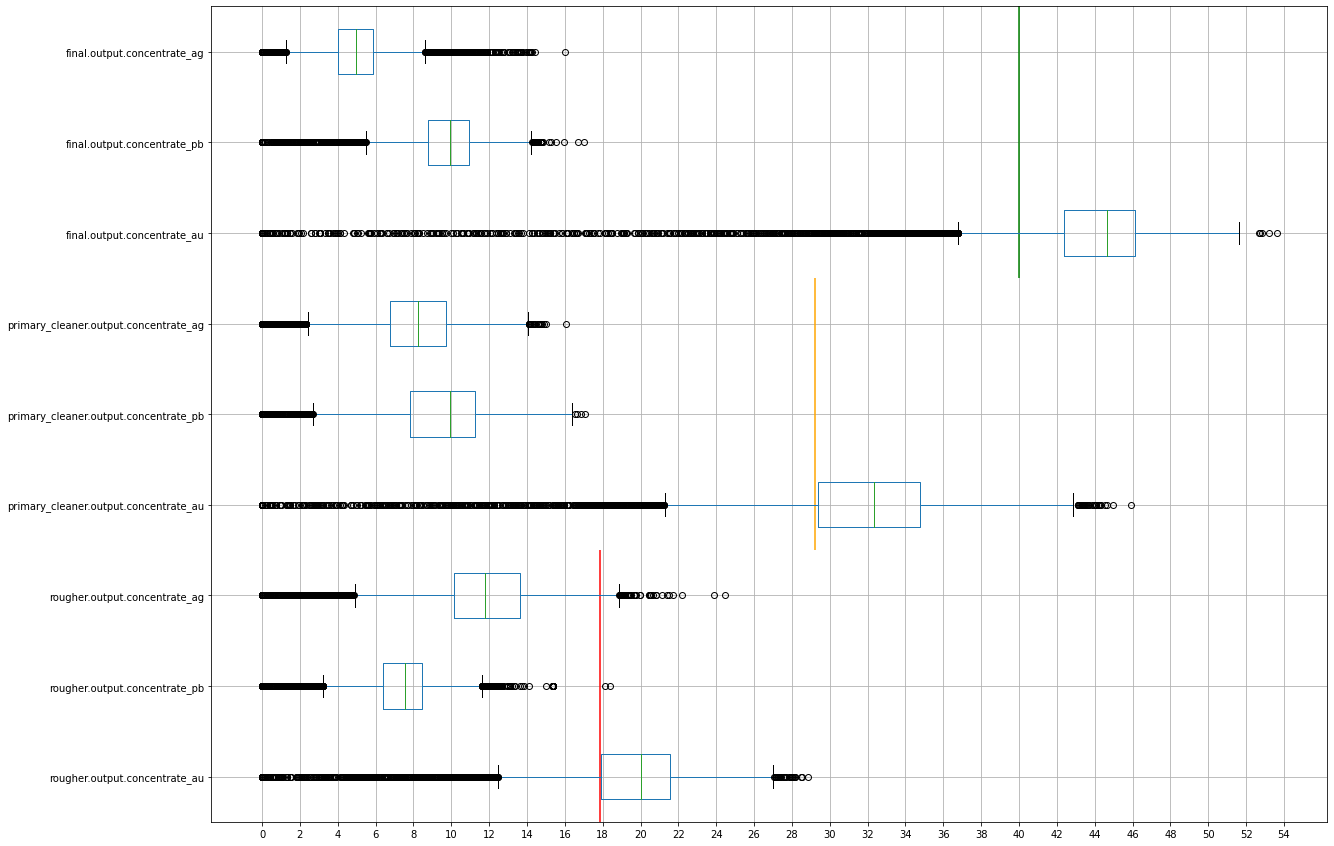

In [11]:
df_full.boxplot(['rougher.output.concentrate_au', 'rougher.output.concentrate_pb', 'rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_au', 'primary_cleaner.output.concentrate_pb', 'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_au', 'final.output.concentrate_pb', 'final.output.concentrate_ag'],figsize=(20,15), vert=False)
plt.xticks(np.arange(0, 55, 2.0))
# Promedio de Rougher del oro en rojo
plt.vlines(df_full['rougher.output.concentrate_au'].mean(),ymin=0.5,ymax=3.5, colors='red')
# Promedio de la purificación primaria del oro en naranja
plt.vlines(df_full['primary_cleaner.output.concentrate_au'].mean(),ymin=3.5,ymax=6.5, colors='orange')
# Promedio de la purificación secundaria del oro en verde
plt.vlines(df_full['final.output.concentrate_au'].mean(),ymin=6.5,ymax=9.5, colors='green')
plt.show()

Existe un claro sesgo con algunos valores bajo la norma. Podríamos eliminar las filas con datos vacíos, pero esto nos haría eliminar más del 10% de los datos totales, demasiada información se perdería. Será mejor llenar los datos vacíos según el comportamiento de los datos en el tiempo. Aprovecharemos que los datos se encuentran ordenados por las fechas y utilizaremos el método `ffill` para que cada dato se llene según el dato anterior en el tiempo.

In [12]:
# Llenemos los sets de entrenamiento y testeo
df_train = df_train.fillna(method='ffill') 
df_test = df_test.fillna(method='ffill') 

# Llenemos también el set completo
df_full = df_full.fillna(method='ffill')

## Análisis de los datos

En esta sección realizaremos 3 actividades:
1. En primer lugar veremos como cambia la concentración de metales (Au, Ag y Pb) en función de la etapa de purificación. Recordemos que el proceso industrial contiene 2 etapas de purificación, por lo que deberiamos ver un aumento en la pureza de los productos. Ya que se busca extraer oro, la cantidad de este metal debería ir en aumento al avanzar por las etapas de purificación. 
2. Compararemos las distribuciones del tamaño de las partículas de la alimentación en el conjunto de entrenamiento y en el conjunto de prueba. Si es que estas distribuciones varían significativamente, la evaluación del modelo no será correcta.
3. Consideraremos las concentraciones totales de todas las sustancias en las diferentes etapas: materia prima, concentrado rougher y concentrado final. Luego responderemos las siguientes preguntas:
    - ¿Se observa algún valor anormal en la distribución total?
    - Si es así, ¿Merece la pena eliminar estos valores de ambas muestras?
    


Comencemos viendo las concentraciones de cada metal. Los datos se encuentran ordenados según la etapa, tipo de parámetro y nombre del parámetro, por lo que necesitamos:
- Etapa: primary_cleaner/secondary_cleaner y final
- Tipo de parámetro: output
- Nombre del parámetro: concentrate_au/tail_au ; concentrate_ag/tail_ag ; concentrate_pb/tail_pb

El concentrado rougher se somete a dos etapas de purificación. Luego de esto, tenemos el concentrado final y las nuevas colas. Esto significa que para cada metal tendremos 4 medidas, siendo el concentrado y la cola de cada proceso de purificación. Como las colas de cada proceso son mucho menores que los concentrados, solo consideraremos los concentrados de cada metal.

### Oro: Au
Primero veamos las concentraciones de oro.

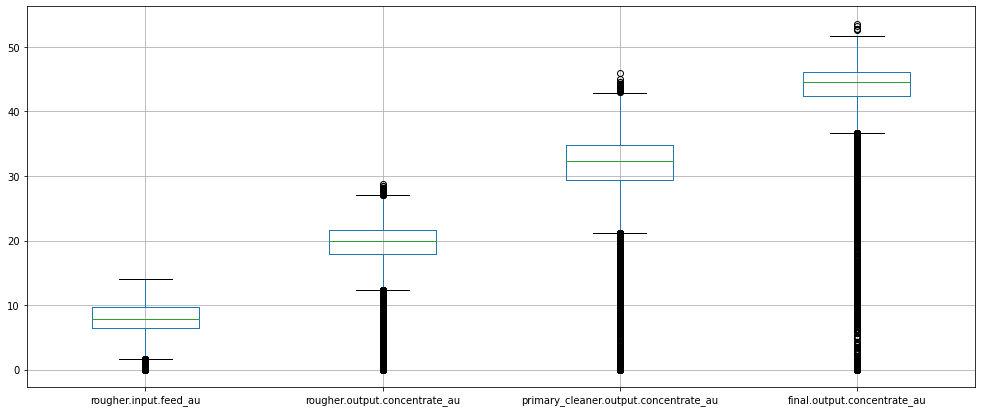

In [13]:
df_full.boxplot(['rougher.input.feed_au', 'rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au'],figsize=(17,7))
plt.show()

Con el paso de cada etapa, las cantidades de oro van aumentando. Esto tiene sentido, pues el objetivo de este proceso es la obtención de oro.

### Plata: Ag

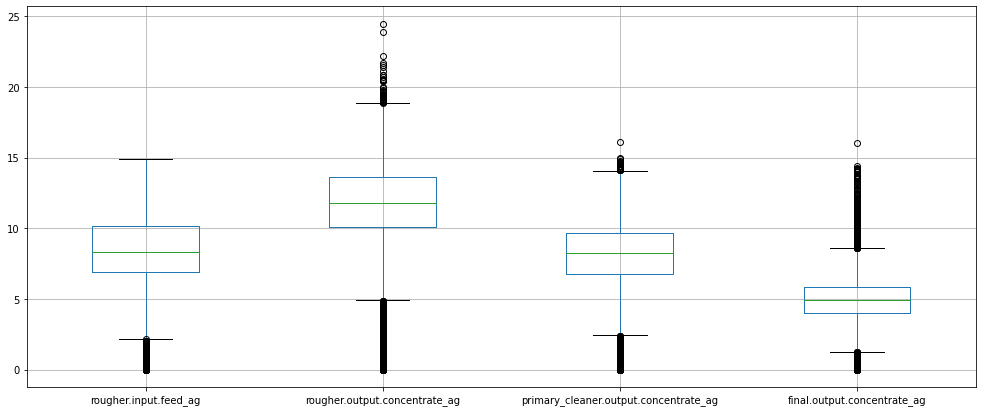

In [14]:
df_full.boxplot(['rougher.input.feed_ag', 'rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag'],figsize=(17,7))
plt.show()

La salida de rougher es el momento con mayor cantidad plata. Probablemente esto se deba a las diferencias de la densidad del oro y la plata, con la plata teniendo casi la mitad de la densidad de contraparte.

### Plomo: Pb

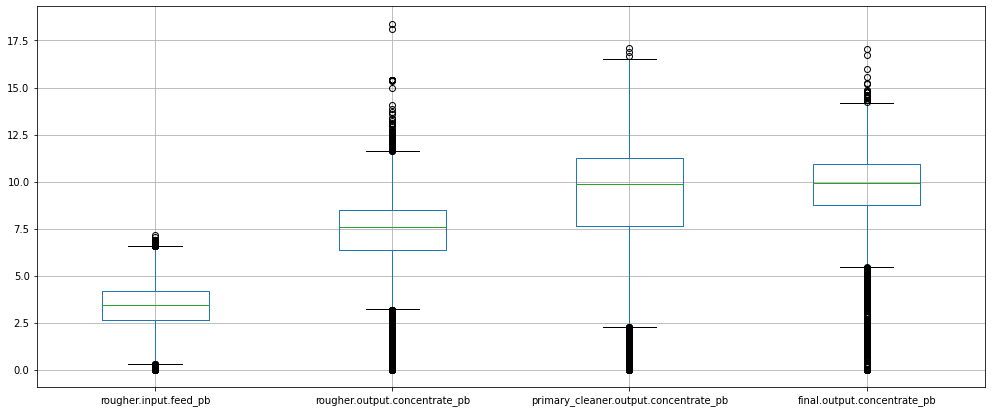

In [15]:
df_full.boxplot(['rougher.input.feed_pb', 'rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb'],figsize=(17,7))
plt.show()

Al igual que con el oro, la cantidad de plomo va aumentando al pasar las etapas, excepto en la última filtración donde parece encontrarse en cantidades más parejas.

## Distribuciones de alimentación
En esta sección compararemos las distribuciones del tamaño de las partículas (`feed_size`) en el conjunto de entrenamiento y de testeo. Consideraremos que existe una alimentación inicial en la etapa rougher y otra al comenzar el proceso de limpieza.

### Columna 'rougher.input.feed_size'

<div class="alert alert-block alert-info">
<b>Aqui estan los dos histogramas uno de cada DataFrame.</b> <a class="tocSkip"></a>
</div>

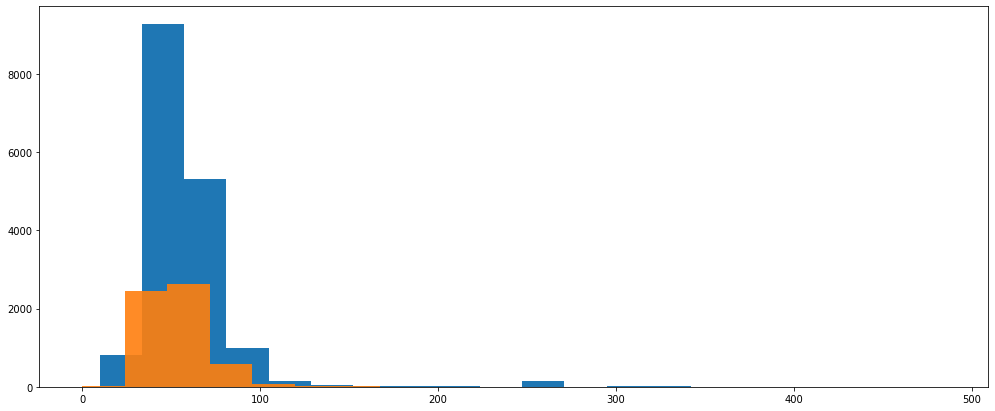

In [16]:
plt.figure(figsize=(17,7))
plt.hist(df_train['rougher.input.feed_size'],bins = 20)
plt.hist(df_test['rougher.input.feed_size'], bins = 20, alpha = .9)
plt.show()

In [17]:
df_train['rougher.input.feed_size'].describe()

count    16860.000000
mean        60.188595
std         30.522242
min          9.659576
25%         47.548897
50%         54.066003
75%         65.397249
max        484.967466
Name: rougher.input.feed_size, dtype: float64

In [18]:
df_test['rougher.input.feed_size'].describe()

count    5856.000000
mean       55.898866
std        22.707969
min         0.046369
25%        43.852884
50%        49.964796
75%        61.628003
max       477.445473
Name: rougher.input.feed_size, dtype: float64

### Columna 'primary_cleaner.input.feed_size'

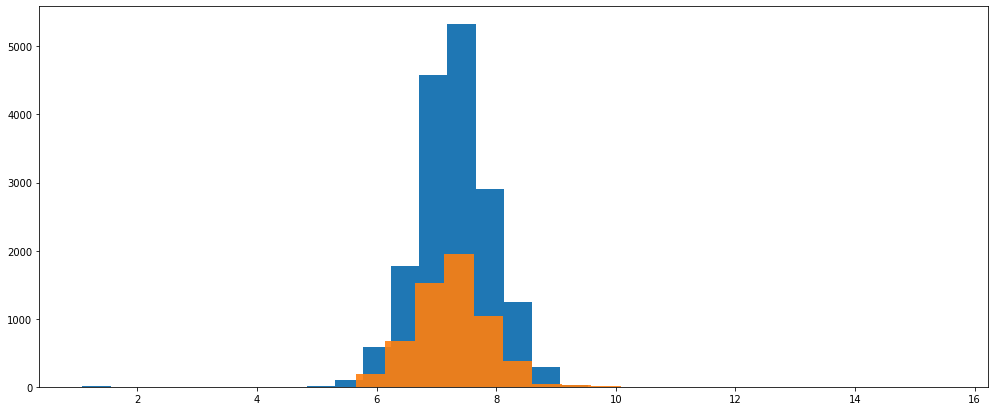

In [19]:
plt.figure(figsize=(17,7))
plt.hist(df_train['primary_cleaner.input.feed_size'], bins=20)
plt.hist(df_test['primary_cleaner.input.feed_size'], bins = 20, alpha = .9)
plt.show()

In [20]:
df_train['primary_cleaner.input.feed_size'].describe()

count    16860.000000
mean         7.297285
std          0.619166
min          1.080000
25%          6.940000
50%          7.285000
75%          7.700000
max         10.470000
Name: primary_cleaner.input.feed_size, dtype: float64

In [21]:
df_test['primary_cleaner.input.feed_size'].describe()

count    5856.000000
mean        7.264651
std         0.611526
min         5.650000
25%         6.885625
50%         7.259333
75%         7.650000
max        15.500000
Name: primary_cleaner.input.feed_size, dtype: float64

### Conclusion
Podemos ver que las cantidades se mantienen bastante parejas para ambos sets de datos, mientras el primero contiene una cantidad mayor de datos atipicos el segundo aunque los contine son mucho menores siendo apenas visibles siguiendo este una distribucion mas normal que las primeras entradas.

También podemos ver que las cantidades de entrada son mucho menores al momento de la primera limpieza despues del proceso rougher. Esto es de esperarse, pues la primera entrada contiene muchos otros elementos extraídos de la mineria que son eliminados en ese primer proceso rougher.

## Concentraciones totales en todas las etapas

Comencemos esta sección recordando las preguntas que necesitamos responder:
- ¿Se observa algún valor anormal en la distribución total?
- Si es así, ¿Merece la pena eliminar estos valores de ambas muestras?

Para esto nos fijaremos en las concentraciones de cada metal en cada etapa y los mediremos con una gráfica de caja y bigotes. Aunque veremos cada metal, solo eliminaremos los valores atípicos según la concentración de oro, al ser este el metal más importante y el objetivo del proceso de filtración.

Aquí quedan las funciones que nos permitirán eliminar los datos atípicos:

In [22]:
# Esta función nos permite encontrar el valor del bigote superior y la usaremos en la siguiente función
def up_iqr_finder (data, column):
    return data[column].quantile(0.75) + (data[column].quantile(0.75) - data[column].quantile(0.25))*1.5


# Esta función nos permite encontrar el valor del bigote inferior y la usaremos en la siguiente función
def down_iqr_finder (data, column):
    return data[column].quantile(0.25) - (data[column].quantile(0.75) - data[column].quantile(0.25))*1.5


# Esta función nos permitirá filtrar el dataset con los valores típicos que se encuentren dentro de los límites de los bigotes
def iqr_limit (data, limit_up, limit_down, column):
    data_set = data[(data[column]<=limit_up) & (data[column]>=limit_down)]
    return data_set

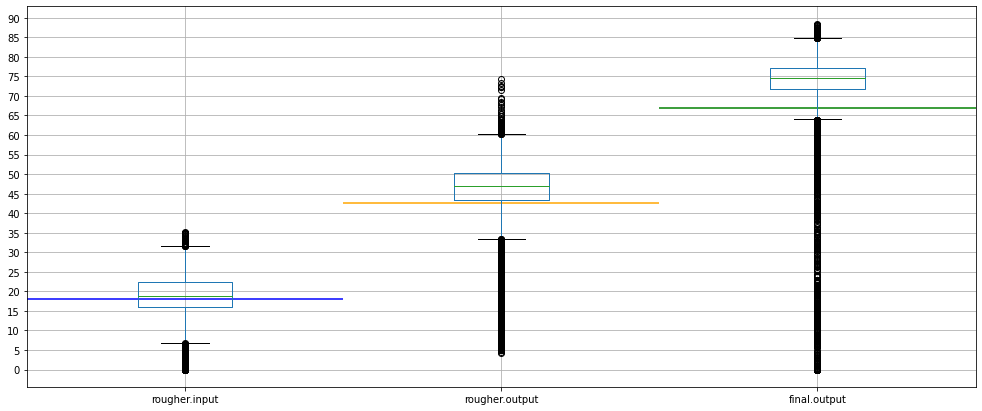

In [23]:
# Juntemos las entradas del proceso Rougher
df_train['rougher.input'] = df_train['rougher.input.feed_ag']+df_train['rougher.input.feed_au']+df_train['rougher.input.feed_pb']

# Juntemos las salidas del proceso Rougher
df_train['rougher.output'] = df_train['rougher.output.concentrate_au']+df_train['rougher.output.concentrate_pb']+df_train['rougher.output.concentrate_ag']+df_train['rougher.output.tail_ag']+df_train['rougher.output.tail_au']+df_train['rougher.output.tail_pb']

# Juntemos las salidas del proceso final
df_train['final.output'] = df_train['final.output.concentrate_au']+df_train['final.output.concentrate_ag']+df_train['final.output.concentrate_pb']+df_train['final.output.tail_au']+df_train['final.output.tail_ag']+df_train['final.output.tail_pb']

# Grafiquemos
df_train.boxplot(['rougher.input', 'rougher.output', 'final.output'], figsize = (17,7))
plt.yticks(np.arange(0, 91, 5))
# Promedio de las entradas del proceso Rougher en azul
plt.hlines(df_train['rougher.input'].mean(),xmin=0.5,xmax=1.5, colors='blue')
# Promedio de las salidas del proceso Rougher en naranja
plt.hlines(df_train['rougher.output'].mean(),xmin=1.5,xmax=2.5, colors='orange')
# Promedio de las salidas del proceso final en verde
plt.hlines(df_train['final.output'].mean(),xmin=2.5,xmax=3.5, colors='green')
plt.show()

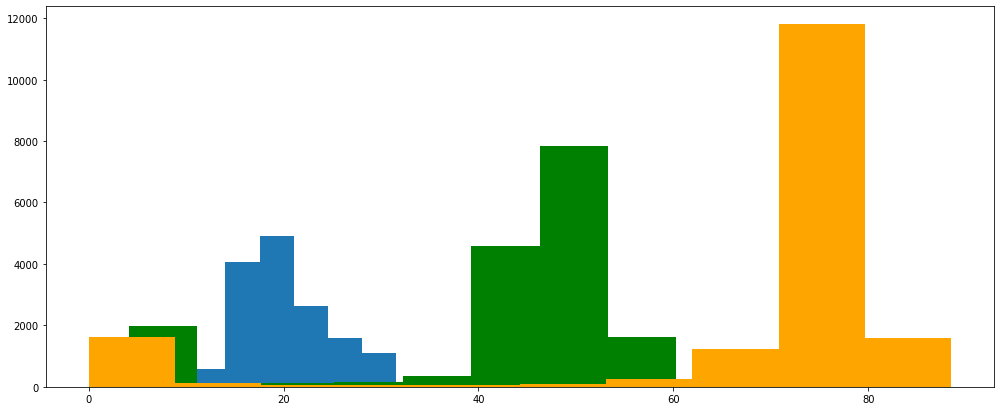

In [24]:
plt.figure(figsize=(17,7))
plt.hist(df_train['rougher.input'])
plt.hist(df_train['rougher.output'], color = 'green')
plt.hist(df_train['final.output'], color = 'orange')
plt.show()

Ya podemos responder la primera pregunta: ¿Se observa algún valor anormal en la distribución total?
- Sí, contamos con varios valores fuera de la norma. En cada etapa estudiada tenemos valores extremos sobre y bajo los bigotes normales de nuestros datos. Además existe un importante grupo de datos cercanos a 0 en cada grupo.

Luego pasamos a la siguiente pregunta: ¿Merece la pena eliminar estos valores de ambas muestras?
- Sí, aunque eliminar todos los datos atípicos resultaría en una perdida muy grande de información. Nos concentraremos en `final.output` y `rougher.output` y eliminaremos las filas con datos atípicos según estas columnas. De ser necesario, se podrían limpiar otras columnas específicas.

### Eliminamos valores atipicos

In [25]:
# Veamos el largo original del set de entrenamiento
print('Largo original:', len(df_train))

# Fijemos los limites de corte
rougher_up = up_iqr_finder(df_train, 'rougher.output')
rougher_down = down_iqr_finder(df_train, 'rougher.output')

final_up = up_iqr_finder(df_train, 'final.output')
final_down = down_iqr_finder(df_train, 'final.output')

# Apliquemos la limpieza de datos atípicos
df_train_clean = iqr_limit(df_train, rougher_up, rougher_down, 'rougher.output')
df_train_clean = iqr_limit(df_train_clean, final_up, final_down, 'final.output')

# Veamos el largo luego de la limpieza
print('Largo post limpieza:', len(df_train_clean))

Largo original: 16860
Largo post limpieza: 13761


Ahora con casi 20% menos de los datos, hemos eliminado los datos atípicos de nuestro set de entrenamiento. No podemos hacer lo mismo con nuestro set de testeo, pues a este le faltan las columnas que hemos estudiado en esta sección. Antes de continuar, volvamos a ver la distribución de los datos luego de la limpieza.

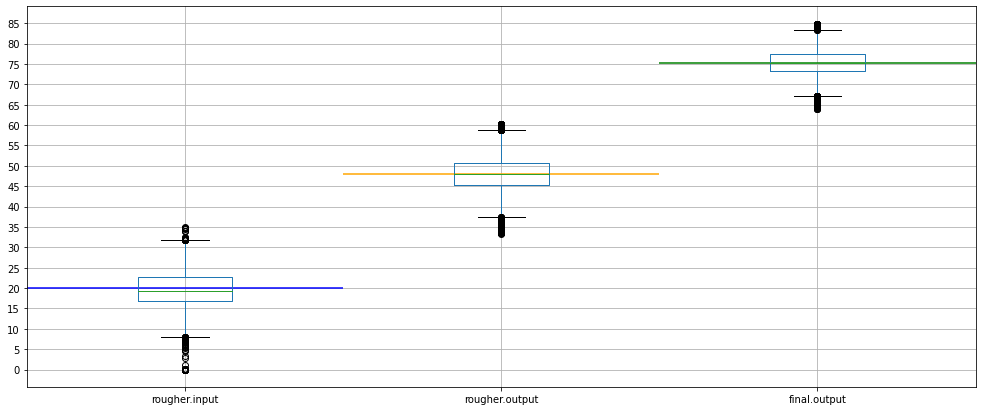

In [26]:
# Grafiquemos
df_train_clean.boxplot(['rougher.input', 'rougher.output', 'final.output'], figsize = (17,7))
plt.yticks(np.arange(0, 91, 5))
# Promedio de las entradas del proceso Rougher en azul
plt.hlines(df_train_clean['rougher.input'].mean(),xmin=0.5,xmax=1.5, colors='blue')
# Promedio de las salidas del proceso Rougher en naranja
plt.hlines(df_train_clean['rougher.output'].mean(),xmin=1.5,xmax=2.5, colors='orange')
# Promedio de las salidas del proceso final en verde
plt.hlines(df_train_clean['final.output'].mean(),xmin=2.5,xmax=3.5, colors='green')
plt.show()

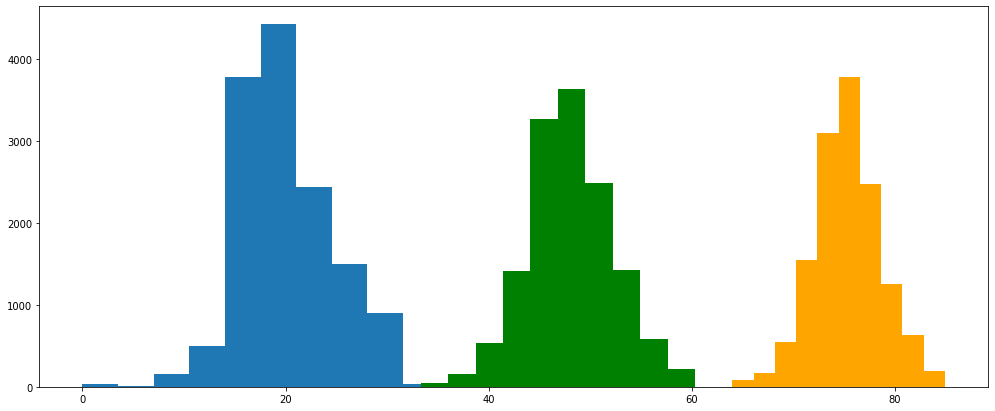

In [27]:
plt.figure(figsize=(17,7))
plt.hist(df_train_clean['rougher.input'])
plt.hist(df_train_clean['rougher.output'], color = 'green')
plt.hist(df_train_clean['final.output'], color = 'orange')
plt.show()

Ahora si podemos ver que los datos se han vuelto parejos y se encuentran ubicados alrededor de la media y mediana en cada columna. 

## Features y Targets

Antes de comenzar con los modelos, necesitamos realizar algunos pasos. Entre estos el primero será crear una semilla que nos ayude a mantener las pruebas estables.

In [28]:
rs = RandomState(54321) # Fijemos una semilla 

### Outputs para nuestro target de testeo

El dataset fuente `df_full` cuenta con todas las características de ambos datasets parciales, `df_train` y `df_test`. La columna `date` se puede usar como indice, por lo que extraeremos las filas con las fechas de `df_test` y nos quedaremos con las columnas que nos faltan para tener nuestros targets de testeo para los modelos. Ya tenemos las columnas que necesitamos extraer en `columns_rest`.

In [29]:
test_date = df_test['date'] # Obtenemos las fechas

test_targets = df_full[df_full['date'].isin(test_date)] # Filtramos df_full segun las fechas de testeo

test_targets = test_targets.loc[:,('rougher.output.recovery', 'final.output.recovery')] # Extraemos las columnas que necesitamos predecir

print(test_targets.shape) # Comprobemos que contamos con todas las filas y columnas que necesitamos

(5856, 2)


Ahora contamos con los targets de testeo. Solo nos queda crear crear los targets y features para el entrenamiento. Trabajaremos en los sets de entrenamiento y testeo, eliminando las columnas que no brindan información y confundirán al modelo predictivo.

### test_features

In [30]:
# Realizamos el mismo proceso que en la sección anterior
test_features = df_full[df_full['date'].isin(test_date)]
test_features = test_features.drop(['date', 'rougher.output.recovery', 'final.output.recovery'], axis=1)

# Nuevamente comprobamos si contamos con las filas y columnas que necesitamos
test_features.shape

(5856, 84)

Con esto ya tenemos los targets y features para el testeo de nuestro modelo.

### train_features
Ahora comenzamos con los datasets para el entrenamiento de nuestro modelo.


In [31]:
train_features = df_train_clean.drop(['date', 'rougher.output.recovery', 'final.output.recovery', 'rougher.input', 'rougher.output',
                                     'final.output'], axis=1)

train_features.shape

(13761, 84)

### train_targets
Repitiremos el proceso anterior, pero esta vez necesitamos las columnas con los targets para nuestro modelo, por lo que usaremos las columnas en `columns_rest`.

In [32]:
train_targets = df_train_clean.loc[:,['rougher.output.recovery', 'final.output.recovery']]

train_targets.shape

(13761, 2)

## Función SMAPE

In [33]:
def final_smape(target, prediction):
    # Función interna
    def smape(target,prediction):
        smape = np.mean((np.abs(target - prediction)/((np.abs(target)+np.abs(prediction))/2))) * 100
        return smape
    
    # Calculo de smape final para Rougher[0] y Final[1]
    smape_rougher = smape(target.iloc[:,0], prediction[:,0]) 
    smape_final   = smape(target.iloc[:,1], prediction[:,1]) 
    final_smape   = (0.25 * smape_rougher) + (0.75 * smape_final)

    return final_smape

sMAPE_score = make_scorer(final_smape, greater_is_better = False)

In [34]:
final_smape

<function __main__.final_smape(target, prediction)>

Con esta función podremos calcular el SMAPE final. También se hace bueno recordar que no necesitamos un modelo que pueda predecir todos los valores de los targets, sino solo la recuperación de las etapas rougher y final. 
Ahora dividiremos el set de entrenamiento para afinar los hiperparámetros de nuestros modelos. Aunque elegiremos al modelo según la evaluación cruzada, mejoraremos cada modelo con los datos que ahora dividiremos.

In [35]:
X_train, y_train, X_test, y_test = train_test_split(train_features, train_targets, test_size=0.25, random_state=rs)

## Modelos predictivos.

Ocuparemos tres modelos Decission Tree, Random Forest y Linear regression y en los primeros dos vamos a ocupar nuevos hiperparametros para tratar de tener una precision mayor aunque eso nos aumentara tambien el tiempo de compilacion esperamos que valga la pena.

### DecisionTreeRegressor

In [36]:
score = 0
for roots in range(3,9):
    for leafs in range(3,9):
        tree = DecisionTreeRegressor(random_state=rs, max_depth=roots, min_samples_leaf=leafs).fit(X_train, X_test)
        sco = np.abs(cross_val_score(tree, test_features, test_targets, scoring=sMAPE_score)).mean()
        if sco>score:
            score = sco
            best_root = roots
            best_leaf = leafs

best_tree = DecisionTreeRegressor(random_state=rs, max_depth=best_root, min_samples_leaf=best_leaf)
np.abs(cross_val_score(best_tree, train_features, train_targets, scoring=sMAPE_score))

array([10.05158551,  6.0904805 ,  6.53194049,  6.70433559, 11.31685951])

In [37]:
np.abs(cross_val_score(best_tree, train_features, train_targets, scoring=sMAPE_score)).mean()

8.139040319747554

### RandomForest

In [38]:
score = 0
for roots in range(3,5):
    for leafs in range(3,5):
        forest = RandomForestRegressor(random_state=rs, max_depth=roots, min_samples_leaf=leafs).fit(X_train, X_test)
        sco = np.abs(cross_val_score(tree, test_features, test_targets, scoring=sMAPE_score)).mean()
        if sco>score:
            score = sco
            best_root = roots
            best_leaf = leafs

best_forest = DecisionTreeRegressor(random_state=rs, max_depth=best_root, min_samples_leaf=best_leaf)
np.abs(cross_val_score(best_forest, train_features, train_targets, scoring=sMAPE_score))

array([10.3028592 ,  6.41648112,  7.23630819,  6.88614865, 10.63869385])

In [39]:
np.abs(cross_val_score(best_forest, train_features, train_targets, scoring=sMAPE_score)).mean()

8.296098203754484

### LinearRegression

In [40]:
reg = LinearRegression()
np.abs(cross_val_score(reg, train_features, train_targets, scoring=sMAPE_score))

array([4.6399519 , 3.46763033, 4.16988969, 3.1942471 , 4.75208397])

In [41]:
np.abs(cross_val_score(reg, train_features, train_targets, scoring=sMAPE_score)).mean()

4.044760598048443

En esta ocacion el modelo que nos da el menor error porcentual es el de Linear Regression muy por debajo de los resultados de los otros dos modelos ahora pasaremos al testeo. 

## Testeo

Ahora finalmente pasemos al testeo de nuestro modelo. Aunque su error debería aumentar, se espera que este nos dé el menor error porcentual entre todos los modelos probados.

In [42]:
# Modelo de bosque aleatorio
best_forest.fit(train_features, train_targets)
pred = best_forest.predict(test_features)
final_smape(test_targets, pred)

10.555233205597402

In [43]:
# Modelo de arbol de decisión
best_tree.fit(train_features, train_targets)
pred = best_tree.predict(test_features)
final_smape(test_targets, pred)

12.290594579376611

In [44]:
# Modelo de regresión linear
reg.fit(train_features, train_targets)
pred = reg.predict(test_features)
final_smape(test_targets, pred)

10.665695639726998

Ahora el modelo con los mejores resultados fue el de decission tree superando al que fue el mejor modelo en entrenamiento linear regression por apenas una decima.

# Conclusión general

Luego de analizar la información, comparar las cantidades de metales en las etapas de purificación, las distribuciones de alimentación a estas etapas y las concentraciones totale en las distintas etapas del proceso, ya podemos contar con datos confiables y dentro de rangos normales. Comenzamos probando 3 modelos predictivos basandonos en la métrica sMAPE. De estos obtuvimos los mejores resultados con `Linear Regression` mucho mejores que los otros dos modelos. Con este modelo logramos obtener el menor error en nuestras predicciones. Alcanzando poco mas de 4 en el momento de testearlo y nuestro modelo con el peor resultado fue `random forest`

Sin embargo al momento de pasar al testeo nuestro mejor modelo fue `random forest` con el menor porcentaje de errores apenas una decima por debajo del modelo de `linear regression`

Se espera que con este modelo podamos predecir los valores de oro producidos por este proceso de purificación. Por lo menos para muestras que se encuentren dentro de rangos normales.